In [123]:
import numpy as np
import matplotlib.pyplot as plt
import itertools #used to generate subsets
from scipy.ndimage import gaussian_filter
from skimage.segmentation import watershed
from skimage.future.graph import RAG
from sknetwork.path import distance
from skimage import util

# import sknetwork as skn
# from scipy import sparse
# import networkx as nx can be used if we need more advanced graphs data structure

In [124]:
#get image and define the image space
image = plt.imread('images/dna-images/gnf/dna-0.png')[...,0]
image_range = np.array([[i,j]for i in range(image.shape[0]) for j in range(image.shape[1])])

In [ ]:
def B_delta(p,delta): #rename suggestion: delta ball
    B = np.empty_like([p])
    for q in image_range:
        if sum(abs(p-q)) <= delta:
            B = np.append(B,[q],axis=0)
    return B

### Algorithm I

In [ ]:
def generate_subgraphs(adjacency):
    #TODO Fehlerabfangen: adjacency symmetric etc.
    dim = adjacency.shape[0]
    vertices = range(dim)
    S = {}
    for length in range(dim+1):
        for subs in list(itertools.combinations(vertices, length)):
            sub_adj = np.zeros((dim, dim))
            if all(adjacency[np.ix_(subs, subs)][k].any(0) > 0 for k in range(len(subs))):
                S[subs] = adjacency[np.ix_(subs, subs)]
               #use this if we need adjacency matrix with original dim 
               # for nodes in subs:
               #     for neighbours in subs:
               #         sub_adj[nodes][neighbours] = adjacency[nodes][neighbours]
               #         sub_adj[neighbours][nodes] = adjacency[nodes][neighbours]
               # S[subs] = sub_adj
    return S
#TODO: still doesn't create subgraphs consisting of one isolated vertex bc all rows are still zero.

In [ ]:
#TODO
def is_connected(adjacency):
    #will do when we're sure what simply connected means

In [ ]:
# Work in Progress to generate all connected subgraphs via a DFS approach.
# Current Problem: error that U.pop() wants to pop an empty list, but idk why it's empty

def generate_connected_subgraphs(adjacency, node): #adjacency needs to be a numpy array
    #TODO: Fehlerabfangen, dass adjacency gültige Form hat
    dim = adjacency.shape[0]
    if node > dim:
        ValueError("Nodes are counted starting 0.")
    T = np.ones(dim)    
    S = np.zeros(dim)
    U = []
    U.append(node)
    T[node] = 0
    
    adj_graph = np.zeros((dim, dim))
    Matrices = []
    
    while U != [] or T != np.zeros(dim):
        if U != []:
            v = U[-1]
            for i in np.where(adjacency[v] == 1)[0]:
                if T[i] == 1:
                    U.append(i)
                    T[i] = 0
                    adj_graph[v][i] = 1
                    adj_graph[i][v] = 1
                    Matrices.append(adj_graph)
                else:
                    S[i] = 1
                    U.pop()
    return Matrices

In [125]:
def generate_fragments(img,std_dev,int_threshold,min_seed_dist,max_search_depth,max_frag_dist):
    #smooth image with gausian filter
    g = gaussian_filter(img,std_dev)
    #create empty copy of g to fill watersheed markers
    g_markers = np.zeros_like(g)
    #create epty copy of g to check for localmax
    g_checked = np.copy(g)
    
    #Fehlerabfangen
    
    if std_dev < 0:
        raise ValueError("smoothing strength needs to be positive")
    if int_threshold > 1 or int_threshold < 0:
        raise ValueError("relative intensity threshold needs to be between 0 and 1")
    if min_seed_dist < 1:
        raise ValueError("min seed distance needs to be >= 1")
    if max_search_depth < 0:
        raise ValueError("maximum search error needs to be positive")
    if max_frag_dist < 0:
        raise ValueError("maximum fragments distance needs zo be positive")
        
    #Create array of watershed seeds
    PI = []
    #Loop while there are still unchecked regions
    while np.amax(g_checked) != 0:
        #Get indicies of g where g is maximal
        glob_max = np.argwhere(g_checked == g_checked.max())
        #Loop over all maximum points
        for p in glob_max:
            #Set boundaries for the local ball B
            upper_bound = [max(0,p[0]-min_seed_dist),max(0,p[1]-min_seed_dist)]
            lower_bound = [min(p[0]+min_seed_dist+1,g.shape[0]),min(p[1]+min_seed_dist+1,g.shape[1])]
            #Create set with local points around p
            B = g[upper_bound[0]:lower_bound[0],upper_bound[1]:lower_bound[1]]
            #Check if p is strong local maximum
            if (g[tuple(p)] == np.amax(B) and (1-int_threshold)*g[tuple(p)] >= np.amin(B)): 
                #add p to the set of seeds
                PI.append(p)
                #Set label of the seed
                g_markers[tuple(p)] = len(PI)
            #Set the Area B = 0
            g_checked[upper_bound[0]:lower_bound[0],upper_bound[1]:lower_bound[1]] = 0
    
    #Create array of watershed regions
    Omega = []
    #Create Watershed regions
    Labels = watershed(util.invert(g),markers=g_markers)
    #loop over all labels
    for label in range(1,len(PI)+1):
        #Create array of the indices of this label
        w = np.argwhere(Labels==label) 
        #Add the array of indices to Omega
        Omega.append(w)
    
    #Create connectivity matrix
    Epsilon = RAG(Labels,connectivity=2)
    '''
    #Loop over number of all regions except the last
    for i in range(len(Omega)-1):
        #Loop over number of not used regions
        for j in range(i+1, len(Omega)):
            #local intensity peaks r(w)??
            if not sum(abs(PI[i] - PI[j])) <= max_frag_dist:
                Epsilon[i,j] = 0
                Epsilon[j,i] = 0   
    S = set()
    subgraphs_set = generate_subgraphs(Epsilon)
    #TODO: add simply connected if-Abfrage
    for i in range(Epsilon.shape[0]): #iterate over all graph vertices
        for subs in subgraphs_set.keys(): 
            if i in range(len(subs)): #find all subgraphs that have i as a node
                dist_matrix = distance(subgraphs_set[subs], method = 'D') #return distance matrix of graph subs
                if dist_matrix[i].max(0) <= h:
                    S.add(subs)
                    #find a way to not iterate over subgraphs we've already worked with
    S = list(S) #transform the set into a list; needed for Alg II
    '''
    return Omega,Labels,Epsilon   # , S

###  testing out graphs

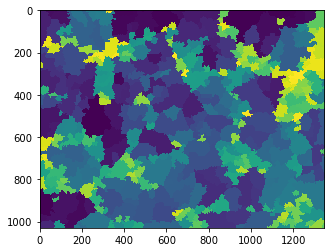

In [128]:
#testing watershed
a,b,c = generate_fragments(image,1,0.1,20,1,40)
plt.imshow(b)
plt.show()
print(c)

In [ ]:
adjacency = np.array([[0, 1, 1, 0], [1, 0, 1, 1], [1, 1, 0, 0], [0, 1, 0, 0]])
#adjacency = sparse.csr_matrix(adjacency)
S = set()
subgraphs_set = generate_subgraphs(adjacency)
for i in range(adjacency.shape[0]): #iterate over all graph vertices
    for subs in subgraphs_set.keys(): 
        if i in subs: #find all subgraphs that have i as a node
            dist_matrix = distance(subgraphs_set[subs], method = 'D') #return distance matrix of graph subs
            if dist_matrix[subs.index(i)].max(0) <= 3:
                S.add(subs)
                #del subgraphs_set[subs] #this changes size during itertaion, ungünstig
                #find a way to not iterate over subgraphs we've already worked with
S = list(S)
S

In [ ]:
for x in generate_subgraphs(adjacency).keys():
    if 1 in x:
        print(x)

### Algorithm II

In [ ]:
def global_solution(f,alpha,Omega,S):
    n = len(S) #stimmt n?
    u = np.zeros(n)
    V = Omega
    Z = S
    while V != ():
#work in progress
        c = np.empty(n)
        for k in range(len(S)):
            c[k] = (f[k] + alpha) / #abs value?
        k_min = argmin(c)
        u[k_min],V = 1, #v\{Z}?
    
    while Z!= set():
        k_prim = 